In [134]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [135]:
DATASET_PATH = "dataset"
X = []  # Almacenar las caracteristicas
y = []  # Almacenar las etiquetas

In [136]:
# Cargar TRAIN (7 imágenes por persona)
print("Cargando TRAIN...")
for label in os.listdir(os.path.join(DATASET_PATH, "train")):
    subcarpeta = os.path.join(DATASET_PATH, "train", label)
    if not os.path.isdir(subcarpeta):
        continue
    
    for img_name in os.listdir(subcarpeta):
        img_path = os.path.join(subcarpeta, img_name)
        
        if not os.path.isfile(img_path):
            continue
            
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            
            img = cv2.resize(img, (128, 128))
            img = cv2.equalizeHist(img)  # Mejor contraste
            
            features = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
            
            X.append(features)
            y.append(label)
        except Exception as e:
            print(f"Error procesando {img_path}: {e}")
            continue

X = np.array(X)
y = np.array(y)

print(f"TRAIN: {len(X)} imagenes, {len(set(y))} personas")

Cargando TRAIN...
TRAIN: 112 imagenes, 16 personas


In [137]:
# Cargar VAL (2 imágenes por persona)
print("Cargando VAL...")
X_val = []
y_val = []

for label in os.listdir(os.path.join(DATASET_PATH, "val")):
    subcarpeta = os.path.join(DATASET_PATH, "val", label)
    if not os.path.isdir(subcarpeta):
        continue
    
    for img_name in os.listdir(subcarpeta):
        img_path = os.path.join(subcarpeta, img_name)
        
        if not os.path.isfile(img_path):
            continue
            
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            
            img = cv2.resize(img, (128, 128))
            img = cv2.equalizeHist(img)
            
            features = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
            
            X_val.append(features)
            y_val.append(label)
        except Exception as e:
            print(f"Error procesando {img_path}: {e}")
            continue

X_val = np.array(X_val)
y_val = np.array(y_val)

print(f"VAL: {len(X_val)} imagenes, {len(set(y_val))} personas")

Cargando VAL...
VAL: 32 imagenes, 16 personas


In [138]:
# Cargar TEST (1 imagen por persona)
print("Cargando TEST...")
X_test = []
y_test = []

for label in os.listdir(os.path.join(DATASET_PATH, "test")):
    subcarpeta = os.path.join(DATASET_PATH, "test", label)
    if not os.path.isdir(subcarpeta):
        continue
    
    for img_name in os.listdir(subcarpeta):
        img_path = os.path.join(subcarpeta, img_name)
        
        if not os.path.isfile(img_path):
            continue
            
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            
            img = cv2.resize(img, (128, 128))
            img = cv2.equalizeHist(img)
            
            features = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
            
            X_test.append(features)
            y_test.append(label)
        except Exception as e:
            print(f"Error procesando {img_path}: {e}")
            continue

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"TEST: {len(X_test)} imagenes, {len(set(y_test))} personas")

Cargando TEST...
TEST: 16 imagenes, 16 personas


In [139]:
# IMPORTANTE: Combinar TRAIN + VAL para maximizar datos de entrenamiento
# Asi usamos 9 imagenes por persona (7 de train + 2 de val) en lugar de solo 7
print("\n=== COMBINANDO TRAIN + VAL ===")
X_train = np.vstack([X, X_val])
y_train = np.concatenate([y, y_val])

print(f"Total para entrenamiento: {len(X_train)} imagenes ({len(X_train)//16} por persona)")
print(f"Total para test: {len(X_test)} imagenes (1 por persona)")


=== COMBINANDO TRAIN + VAL ===
Total para entrenamiento: 144 imagenes (9 por persona)
Total para test: 16 imagenes (1 por persona)


In [140]:
# Normalizar datos (mejora mucho el rendimiento)
print("\nNormalizando caracteristicas...")
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
std[std == 0] = 1

X_train_norm = (X_train - mean) / std
X_test_norm = (X_test - mean) / std
print("Normalizacion completada")


Normalizando caracteristicas...
Normalizacion completada


In [141]:
print("\n=== ENTRENANDO MODELO ===")

# Parametros optimizados para dataset con pocas imagenes
model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
model.fit(X_train_norm, y_train)

print("Modelo entrenado exitosamente")


=== ENTRENANDO MODELO ===
Modelo entrenado exitosamente


In [142]:
print("\n=== EVALUACION EN TEST ===")
y_pred_test = model.predict(X_test_norm)

accuracy = accuracy_score(y_test, y_pred_test)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
print(f"\nReport:")
print(classification_report(y_test, y_pred_test, zero_division=0))


=== EVALUACION EN TEST ===

Accuracy: 1.0000 (100.0%)

Report:
              precision    recall  f1-score   support

    AAlegria       1.00      1.00      1.00         1
       ALara       1.00      1.00      1.00         1
      ASaula       1.00      1.00      1.00         1
    BPepinos       1.00      1.00      1.00         1
  CCalapucha       1.00      1.00      1.00         1
     EChuico       1.00      1.00      1.00         1
   EZambrano       1.00      1.00      1.00         1
    FJimenez       1.00      1.00      1.00         1
   HQuintero       1.00      1.00      1.00         1
     JFranco       1.00      1.00      1.00         1
     JGuerra       1.00      1.00      1.00         1
    JJimenez       1.00      1.00      1.00         1
     JTorres       1.00      1.00      1.00         1
     MMolina       1.00      1.00      1.00         1
      PTapia       1.00      1.00      1.00         1
 RPuruncajas       1.00      1.00      1.00         1

    accuracy    

In [143]:
# Analisis detallado de predicciones
print("\n=== ANALISIS DETALLADO ===")
print(f"{'Persona':<15} {'Prediccion':<15} {'Resultado'}")
print("-" * 50)

correctos = 0
errores_lista = []

for real, pred in zip(y_test, y_pred_test):
    resultado = "CORRECTO" if real == pred else "ERROR"
    simbolo = "✓" if real == pred else "✗"
    print(f"{real:<15} {pred:<15} {simbolo} {resultado}")
    
    if real == pred:
        correctos += 1
    else:
        errores_lista.append((real, pred))

print(f"\nResumen:")
print(f"  Correctos: {correctos}/{len(y_test)} ({correctos/len(y_test)*100:.1f}%)")
print(f"  Errores: {len(errores_lista)}/{len(y_test)}")

if errores_lista:
    print(f"\nPersonas mal clasificadas:")
    for real, pred in errores_lista:
        print(f"  - {real} -> clasificado como {pred}")


=== ANALISIS DETALLADO ===
Persona         Prediccion      Resultado
--------------------------------------------------
AAlegria        AAlegria        ✓ CORRECTO
ALara           ALara           ✓ CORRECTO
ASaula          ASaula          ✓ CORRECTO
BPepinos        BPepinos        ✓ CORRECTO
CCalapucha      CCalapucha      ✓ CORRECTO
EChuico         EChuico         ✓ CORRECTO
EZambrano       EZambrano       ✓ CORRECTO
FJimenez        FJimenez        ✓ CORRECTO
HQuintero       HQuintero       ✓ CORRECTO
JFranco         JFranco         ✓ CORRECTO
JGuerra         JGuerra         ✓ CORRECTO
JJimenez        JJimenez        ✓ CORRECTO
JTorres         JTorres         ✓ CORRECTO
MMolina         MMolina         ✓ CORRECTO
PTapia          PTapia          ✓ CORRECTO
RPuruncajas     RPuruncajas     ✓ CORRECTO

Resumen:
  Correctos: 16/16 (100.0%)
  Errores: 0/16



IMAGENES DISPONIBLES PARA PROBAR:
1. AAlegria - img_10.jpeg
2. ALara - img_10.jpeg
3. ASaula - img_10.jpeg
4. BPepinos - img_10.jpeg
5. CCalapucha - img_10.jpeg
6. EChuico - img_10.jpeg
7. EZambrano - img_1.jpg
8. FJimenez - img_10.jpeg
9. HQuintero - img_10.jpg
10. JFranco - img_10.jpeg
11. JGuerra - img_10.jpg
12. JJimenez - img_10.jpeg
13. JTorres - img_10.jpeg
14. MMolina - img_10.jpeg
15. PTapia - img_10.jpeg
16. RPuruncajas - img_10.jpeg


PREDICCION #15
Persona real: PTapia
Predicción: EChuico
Resultado: ✗ ERROR



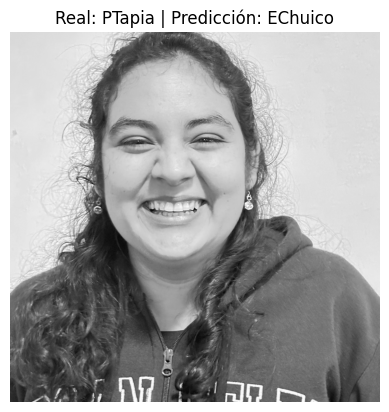

In [154]:
import os

def listar_imagenes_test():
    """
    Lista todas las imágenes de test con números
    """
    base_path = './dataset/test'
    personas = sorted(os.listdir(base_path))
    
    imagenes_disponibles = []
    contador = 1
    
    print("\n" + "="*60)
    print("IMAGENES DISPONIBLES PARA PROBAR:")
    print("="*60)
    
    for persona in personas:
        persona_path = os.path.join(base_path, persona)
        imagenes = sorted(os.listdir(persona_path))
        
        for img in imagenes:
            ruta_completa = os.path.join(persona_path, img)
            imagenes_disponibles.append((contador, persona, ruta_completa))
            print(f"{contador}. {persona} - {img}")
            contador += 1
    
    print("="*60 + "\n")
    return imagenes_disponibles


def predecir_por_numero(numero, imagenes_disponibles):
    """
    Predice basándose en el número elegido
    """
    # Buscar la imagen
    imagen_info = None
    for num, persona, ruta in imagenes_disponibles:
        if num == numero:
            imagen_info = (persona, ruta)
            break
    
    if imagen_info is None:
        print(f"Error: No existe la imagen número {numero}")
        return
    
    persona_real, ruta = imagen_info
    
    print(f"\n{'='*60}")
    print(f"PREDICCION #{numero}")
    print(f"{'='*60}")
    print(f"Persona real: {persona_real}")
    
    # Leer y procesar - CAMBIO AQUÍ: 90x90 en lugar de 100x100
    img = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (90, 90))  # ← CAMBIO AQUÍ
    img_flattened = img_resized.flatten().reshape(1, -1)
    img_normalized = scaler.transform(img_flattened)
    
    # Predecir
    prediccion = model.predict(img_normalized)[0]
    
    print(f"Predicción: {prediccion}")
    print(f"Resultado: {'✓ CORRECTO' if prediccion == persona_real else '✗ ERROR'}")
    print(f"{'='*60}\n")
    
    # Mostrar imagen
    plt.imshow(img, cmap='gray')
    plt.title(f"Real: {persona_real} | Predicción: {prediccion}")
    plt.axis('off')
    plt.show()


# ==== USAR ASÍ ====

# 1. Listar todas las imágenes
imagenes = listar_imagenes_test()

# 2. Elegir por número
predecir_por_numero(15, imagenes)